# Healthcare Analytics Pipeline

## Imports libraries

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
from dotenv import load_dotenv
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


## Connection

In [2]:
# Load environment variables
load_dotenv()

# Fetch credentials
username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
database = os.getenv('DB_DATABASE')

# Create the connection URL
connection_url = f'postgresql://{username}:{password}@{host}:{port}/{database}'

In [3]:
try:
    # Try to create the engine and connect
    engine = create_engine(connection_url)
    connection = engine.connect()
    print("Database connection successful.")
except SQLAlchemyError as e:
    print("Database connection failed.")
    print(e)
    exit(1)  # Stop the script if connection fails

Database connection successful.


## Data Ingestion

In [4]:
# Function to read a table safely
def read_table(table_name, engine):
    try:
        df = pd.read_sql(f"SELECT * FROM {table_name}", con=engine)
        print(f"Successfully read table '{table_name}'.")
        return df
    except SQLAlchemyError as e:
        print(f"Failed to read table '{table_name}'.")
        print(e)
        return None

In [5]:
# Query into a DataFrame
tables = ["patients", "appointments", "providers", "prescriptions", "categories"]
dfs = {}

for table in tables:
    df = read_table(table, engine)
    if df is not None:
        dfs[table] = df
    
connection.close()

Successfully read table 'patients'.
Successfully read table 'appointments'.
Successfully read table 'providers'.
Successfully read table 'prescriptions'.
Successfully read table 'categories'.


In [6]:
dfs["patients"].head()

,patient_id,name,age,gender,registration_date
0,1,John Hill,89.0,Male,2023-08-23
1,2,Adam Chavez,21.0,Male,2024-04-01
2,3,Troy Scott,36.0,Male,2020-03-04
3,4,Joan Ross,77.0,Female,2021-09-24
4,5,Stephanie Giles,41.0,Female,2022-08-17


In [7]:
dfs["appointments"].head()

,appointment_id,patient_id,appointment_date,appointment_type,provider_id
0,1,37,2023-02-25,Checkup,4
1,2,36,2023-03-10,Emergency,7
2,3,46,2023-04-02,Checkup,3
3,4,1,2023-01-16,Consultation,6
4,5,42,2023-03-24,Emergency,4


In [8]:
dfs["providers"].head()

,provider_id,name,specialty
0,1,Tiffany Thompson,Pediatrics
1,2,Renee Brooks,Orthopedics
2,3,Joseph Johnson,Neurology
3,4,Todd Jones,Pediatrics
4,5,Edward Rodriguez,Cardiology


In [9]:
dfs["prescriptions"].head()

,prescription_id,patient_id,medication_name,prescription_date,id_category
0,1,15,Ibuprofen,2023-04-07,1
1,2,8,Metformin,2023-01-24,2
2,3,37,Lisinopril,2023-03-03,3
3,4,23,Atorvastatin,2023-01-14,3
4,5,24,Atorvastatin,2023-03-29,3


In [10]:
dfs["categories"].head()

,id_category,category_name
0,1,Pain Relief
1,2,Diabetes
2,3,Heart
3,4,Antibiotic
4,5,Common


## Data Transformation

In [11]:
today = pd.to_datetime(datetime.now())

### Patient-level transformations

In [12]:
# Age group (0-18, 19-30, 31-50, 51-70, 71+)

# min_age = int(dfs["patients"]["age"].min())
max_age = int(dfs["patients"]["age"].max())

# Define bins and labels
bins = [0, 18, 30, 50, 70, max_age]
labels = ["0-18", "19-30", "31-50", "51-70", "71+"]

dfs["patients"]["Age Group"] = pd.cut(dfs["patients"]["age"], bins=bins, labels=labels, right=True)

dfs["patients"].sample(10)



,patient_id,name,age,gender,registration_date,Age Group
28,29,Angela Wright,23.0,Female,2023-04-11,19-30
37,38,Elizabeth Davis,72.0,Female,2023-01-06,71+
20,21,Emily Johnson,75.0,Female,2024-06-13,71+
38,39,Courtney Wilkerson,76.0,Female,2022-03-12,71+
4,5,Stephanie Giles,41.0,Female,2022-08-17,31-50
13,14,Teresa Clark,56.0,Female,2023-05-11,51-70
11,12,Mary Hernandez,53.0,Female,2022-04-10,51-70
9,10,Leonard Lewis,53.0,Male,2023-11-12,51-70
6,7,Edward Roberts,53.0,Male,2025-01-22,51-70
17,18,Tina James,46.0,Female,2023-11-04,31-50


In [13]:
# Patient type (New: registered < 6 months, Regular: 6-24 months, Long-term: > 24 months)

dfs["patients"]["registration_date"] = pd.to_datetime(dfs["patients"]["registration_date"])

# (current year - registration year) * 12 + (current month - registration mont)
dfs["patients"]["months"] = (today.year - dfs["patients"]["registration_date"].dt.year) * 12 + (today.month - dfs["patients"]["registration_date"].dt.month)

max_month = int(dfs["patients"]["months"].max())

# Define bins and labels
bins = [0, 6, 24, max_month]
labels = ["New", "Regular", "Long-term"]

dfs["patients"]["Patient type"] = pd.cut(dfs["patients"]["months"], bins=bins, labels=labels, right=False)
dfs["patients"].drop(columns=["months"], inplace=True)


dfs["patients"].sample(10)




,patient_id,name,age,gender,registration_date,Age Group,Patient type
43,44,Virginia Cross,49.0,Female,2023-08-20,31-50,Regular
13,14,Teresa Clark,56.0,Female,2023-05-11,51-70,Long-term
41,42,John Hanson,21.0,Male,2023-08-05,19-30,Regular
52,53,Thomas Brown,NaN,Male,2023-02-10,NaN,Long-term
32,33,Nicole Taylor,31.0,Female,2020-01-05,31-50,NaN
33,34,Brian Williams,73.0,Male,2021-03-04,71+,Long-term
21,22,James Keith,49.0,Male,2021-06-20,31-50,Long-term
11,12,Mary Hernandez,53.0,Female,2022-04-10,51-70,Long-term
27,28,Michael Palmer,74.0,Male,2020-06-08,71+,Long-term
53,54,Jennifer Davis,NaN,Female,2023-04-05,NaN,Long-term


### Appointment-level transformations

In [14]:
dfs["appointments"]["appointment_date"] = pd.to_datetime(dfs["appointments"]["appointment_date"])

In [15]:
# Day of week (Monday-Sunday)

dfs["appointments"]["Day of week"] = dfs["appointments"]["appointment_date"].dt.day_name()
dfs["appointments"].sample(10)

,appointment_id,patient_id,appointment_date,appointment_type,provider_id,Day of week
67,68,22,2023-01-13,Checkup,4,Friday
53,54,37,2023-01-13,Consultation,3,Friday
99,100,49,2023-04-03,Emergency,9,Monday
55,56,46,2023-03-23,Consultation,2,Thursday
57,58,33,2023-04-03,Checkup,9,Monday
91,92,44,2023-02-24,Emergency,2,Friday
18,19,20,2023-03-07,Checkup,7,Tuesday
46,47,17,2023-01-21,Consultation,5,Saturday
7,8,31,2023-02-16,Checkup,1,Thursday
83,84,48,2023-01-07,Emergency,8,Saturday


In [16]:
# Time since last appointment (in days)
dfs["appointments"]["days_since_last_appointment"] = (today - dfs["appointments"]["appointment_date"]).dt.days
dfs["appointments"].sample(10)

,appointment_id,patient_id,appointment_date,appointment_type,provider_id,Day of week,days_since_last_appointment
70,71,44,2023-03-12,Emergency,9,Sunday,782
66,67,27,2023-01-09,Emergency,6,Monday,844
104,105,55,2022-12-25,Consultation,3,Sunday,859
1,2,36,2023-03-10,Emergency,7,Friday,784
72,73,28,2023-04-04,Consultation,9,Tuesday,759
93,94,2,2023-01-12,Consultation,9,Thursday,841
62,63,27,2023-03-19,Checkup,5,Sunday,775
39,40,48,2023-02-16,Emergency,7,Thursday,806
89,90,43,2023-02-09,Consultation,5,Thursday,813
82,83,18,2023-01-02,Emergency,1,Monday,851


### Prescription-level transformations

In [17]:
# Medication category (e.g., Pain Relief, Diabetes, Heart, etc.)
dfs["prescriptions"] = dfs["prescriptions"].merge(dfs["categories"], on="id_category", how="inner")
dfs["prescriptions"].sample(10)

,prescription_id,patient_id,medication_name,prescription_date,id_category,category_name
87,88,26,Metformin,2023-01-31,2,Diabetes
1,2,8,Metformin,2023-01-24,2,Diabetes
126,127,22,Aspirin,2023-04-03,5,Common
7,8,36,Aspirin,2023-04-07,5,Common
3,4,23,Atorvastatin,2023-01-14,3,Heart
34,35,30,Lisinopril,2023-04-03,3,Heart
29,30,40,Aspirin,2023-01-20,5,Common
12,13,2,Ibuprofen,2023-01-15,1,Pain Relief
78,79,17,Ibuprofen,2023-03-31,1,Pain Relief
124,125,15,Ibuprofen,2023-04-08,1,Pain Relief


In [18]:
# Prescription frequency (First-time, Repeat)
dfs["prescriptions"]["Prescription frequency"] = dfs["prescriptions"]["patient_id"].duplicated(keep="first").map({False: "First-time", True: "Repeat"})
dfs["prescriptions"].sample(10)

,prescription_id,patient_id,medication_name,prescription_date,id_category,category_name,Prescription frequency
28,29,22,Aspirin,2023-04-02,5,Common,Repeat
125,126,15,Ibuprofen,2023-04-09,1,Pain Relief,Repeat
90,91,12,Amoxicillin,2023-04-05,4,Antibiotic,Repeat
42,43,49,Atorvastatin,2023-01-13,3,Heart,Repeat
98,99,10,Aspirin,2023-02-11,5,Common,Repeat
84,85,8,Ibuprofen,2023-02-10,1,Pain Relief,Repeat
78,79,17,Ibuprofen,2023-03-31,1,Pain Relief,First-time
68,69,8,Atorvastatin,2023-01-24,3,Heart,Repeat
15,16,44,Atorvastatin,2023-02-24,3,Heart,First-time
118,119,8,Ibuprofen,2023-02-14,1,Pain Relief,Repeat


## Data Analysis

In [19]:
df_patients_appointments = dfs["patients"].merge(dfs["appointments"], on="patient_id", how="left")
df_patients_appointments.sample(5)

,patient_id,name,age,gender,registration_date,Age Group,Patient type,appointment_id,appointment_date,appointment_type,provider_id,Day of week,days_since_last_appointment
21,12,Mary Hernandez,53.0,Female,2022-04-10,51-70,Long-term,91.0,2023-03-25,Checkup,6.0,Saturday,769.0
20,11,Christine Sparks,39.0,Female,2024-06-29,31-50,Regular,98.0,2023-04-06,Consultation,9.0,Thursday,757.0
86,44,Virginia Cross,49.0,Female,2023-08-20,31-50,Regular,27.0,2023-02-04,Checkup,1.0,Saturday,818.0
12,7,Edward Roberts,53.0,Male,2025-01-22,51-70,New,96.0,2023-01-16,Consultation,8.0,Monday,837.0
70,36,Colin Sanders,40.0,Male,2024-03-25,31-50,Regular,2.0,2023-03-10,Emergency,7.0,Friday,784.0


### Patient Analysis

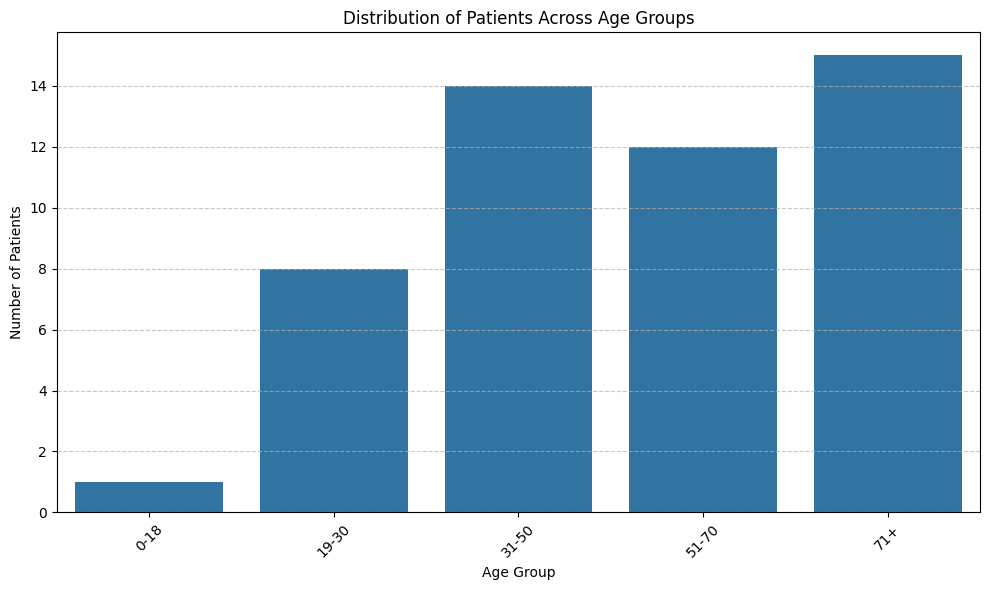

In [20]:
# What is the distribution of patients across age groups?
plt.figure(figsize=(10,6))
sns.countplot(data=dfs["patients"] , x="Age Group")

plt.title("Distribution of Patients Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
# How does the appointment frequency vary by patient type?
df_grouped = (
    df_patients_appointments
    .groupby(["Patient type", "patient_id"], observed=False)["appointment_id"]
    .count()
    .reset_index(name="appointment_count")
)
df_grouped = df_grouped[df_grouped["appointment_count"] > 0]
df_grouped.sample(10)

,Patient type,patient_id,appointment_count
150,Long-term,41,1
117,Long-term,8,3
6,New,7,3
97,Regular,43,3
161,Long-term,52,1
71,Regular,17,3
85,Regular,31,3
156,Long-term,47,1
162,Long-term,53,1
136,Long-term,27,5


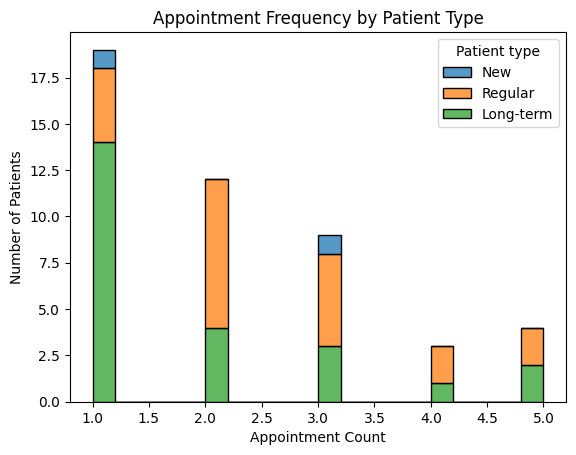

In [36]:
sns.histplot(
    data=df_grouped,
    x="appointment_count",
    hue="Patient type",
    multiple="stack",
    bins=20
)
plt.title("Appointment Frequency by Patient Type")
plt.xlabel("Appointment Count")
plt.ylabel("Number of Patients")
plt.show()

In [23]:
# Summary statistics by patient type
summary = df_grouped.groupby("Patient type", observed=False)["appointment_count"].agg(["count", "mean", "median", "min", "max", "std"]).sort_values("mean", ascending=False)
print(summary)


              count      mean  median  min  max       std
Patient type                                             
Regular          55  0.963636     0.0    0    5  1.439697
Long-term        55  0.818182     0.0    0    5  1.263313
New              55  0.072727     0.0    0    3  0.424026


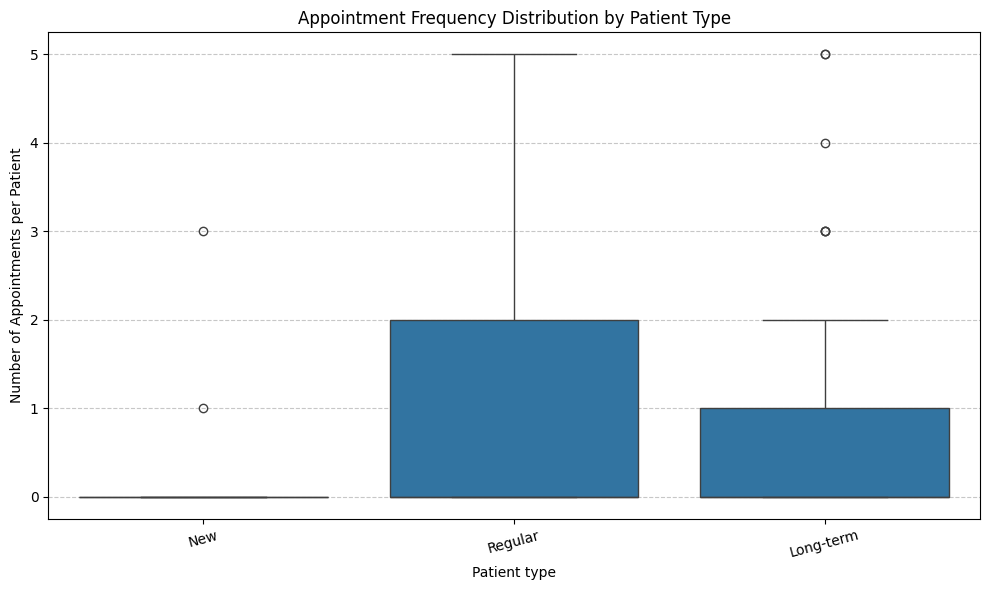

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_grouped, x="Patient type", y="appointment_count")
plt.title("Appointment Frequency Distribution by Patient Type")
plt.ylabel("Number of Appointments per Patient")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Appointment Analysis

In [25]:
df_patients_appointments

,patient_id,name,age,gender,registration_date,Age Group,Patient type,appointment_id,appointment_date,appointment_type,provider_id,Day of week,days_since_last_appointment
0,1,John Hill,89.0,Male,2023-08-23,71+,Regular,4.0,2023-01-16,Consultation,6.0,Monday,837.0
1,1,John Hill,89.0,Male,2023-08-23,71+,Regular,75.0,2023-03-18,Checkup,5.0,Saturday,776.0
2,1,John Hill,89.0,Male,2023-08-23,71+,Regular,76.0,2023-04-04,Consultation,2.0,Tuesday,759.0
3,2,Adam Chavez,21.0,Male,2024-04-01,19-30,Regular,60.0,2023-01-06,Emergency,4.0,Friday,847.0
4,2,Adam Chavez,21.0,Male,2024-04-01,19-30,Regular,94.0,2023-01-12,Consultation,9.0,Thursday,841.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,51,Robert Johnson,NaN,Male,2023-01-15,NaN,Long-term,101.0,2022-12-15,Checkup,4.0,Thursday,869.0
108,52,Margaret Smith,NaN,Female,2023-03-20,NaN,Long-term,102.0,2023-01-20,Consultation,2.0,Friday,833.0
109,53,Thomas Brown,NaN,Male,2023-02-10,NaN,Long-term,103.0,2023-01-10,Emergency,7.0,Tuesday,843.0
110,54,Jennifer Davis,NaN,Female,2023-04-05,NaN,Long-term,104.0,2023-02-05,Checkup,5.0,Sunday,817.0


In [26]:
# What are the most common appointment types by age group?
df_grouped = (
    df_patients_appointments
    .groupby(["Age Group", "appointment_type"], observed=False)["appointment_id"]
    .count()
    .reset_index(name="appointment_count")
)

idx = df_grouped.groupby("Age Group", observed=False)["appointment_count"].idxmax()

most_common_per_age_group = df_grouped.loc[idx].reset_index(drop=True)

most_common_per_age_group

,Age Group,appointment_type,appointment_count
0,0-18,Consultation,2
1,19-30,Emergency,8
2,31-50,Consultation,10
3,51-70,Checkup,14
4,71+,Checkup,13


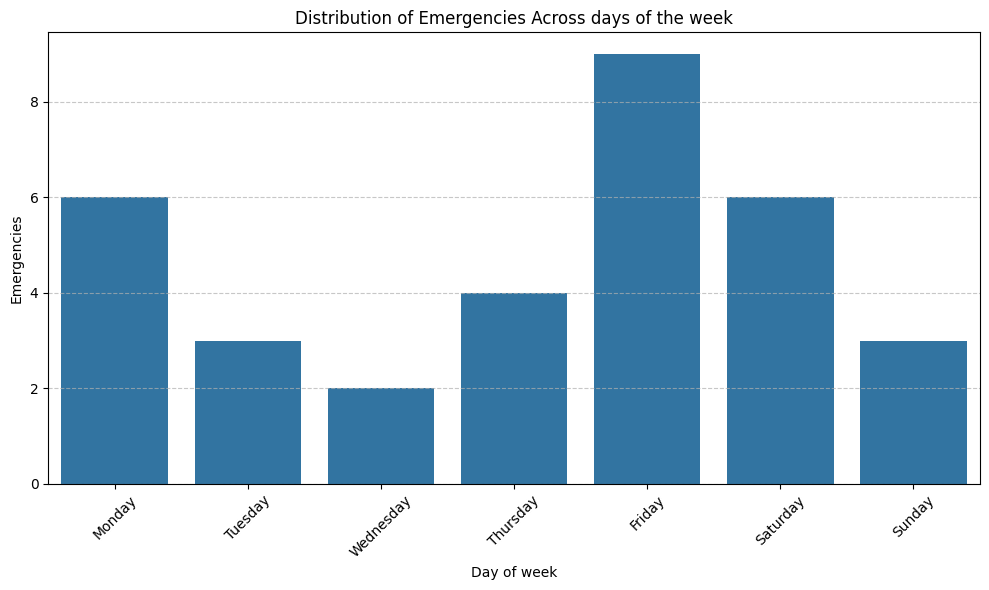

In [27]:
# Are there specific days of the week with higher emergency visits?
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_emergency = dfs["appointments"][dfs["appointments"]["appointment_type"] == "Emergency"]

plt.figure(figsize=(10,6))
sns.countplot(data=df_emergency , x="Day of week", order=day_order)

plt.title("Distribution of Emergencies Across days of the week")
plt.xlabel("Day of week")
plt.ylabel("Emergencies")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Prescription Analysis

In [28]:
df_prescriptions_patient = dfs["prescriptions"].merge(dfs["patients"].loc[:, ["patient_id", "Age Group"]], on="patient_id", how="inner")
df_prescriptions_patient.sample(10)

,prescription_id,patient_id,medication_name,prescription_date,id_category,category_name,Prescription frequency,Age Group
54,55,26,Atorvastatin,2023-01-12,3,Heart,First-time,51-70
79,80,21,Aspirin,2023-02-02,5,Common,Repeat,71+
93,94,9,Amoxicillin,2023-03-21,4,Antibiotic,Repeat,71+
73,74,39,Atorvastatin,2023-02-18,3,Heart,First-time,71+
80,81,28,Ibuprofen,2023-03-09,1,Pain Relief,Repeat,71+
91,92,16,Amoxicillin,2023-01-13,4,Antibiotic,First-time,51-70
18,19,18,Atorvastatin,2023-03-30,3,Heart,First-time,31-50
89,90,27,Aspirin,2023-03-07,5,Common,Repeat,71+
81,82,22,Atorvastatin,2023-02-16,3,Heart,Repeat,31-50
60,61,30,Ibuprofen,2023-02-27,1,Pain Relief,Repeat,31-50


In [29]:
# What are the most prescribed medication categories by age group?
df_grouped = (
    df_prescriptions_patient
    .groupby(["Age Group", "category_name"], observed=False)["prescription_id"]
    .count()
    .reset_index(name="prescription_count")
)

idx = df_grouped.groupby("Age Group", observed=False)["prescription_count"].idxmax()

most_common_per_age_group = df_grouped.loc[idx].reset_index(drop=True)

most_common_per_age_group

,Age Group,category_name,prescription_count
0,0-18,Antibiotic,1
1,19-30,Heart,4
2,31-50,Heart,16
3,51-70,Common,10
4,71+,Heart,13


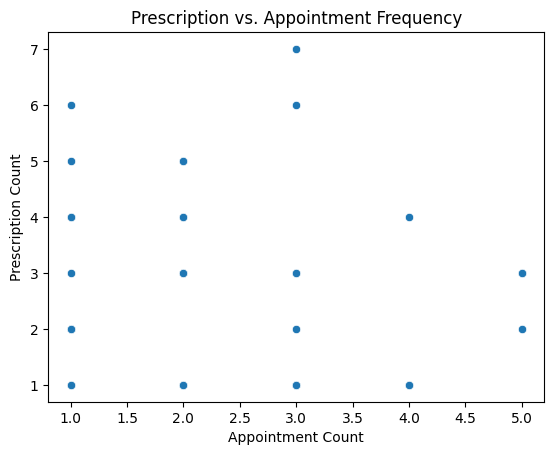

Pearson correlation: -0.09


In [37]:
# How does prescription frequency correlate with appointment frequency?

# Step 1: Count appointments per patient
appointment_counts = dfs["appointments"].groupby("patient_id").size().reset_index(name="appointment_count")

# Step 2: Count prescriptions per patient
prescription_counts = dfs["prescriptions"].groupby("patient_id").size().reset_index(name="prescription_count")

# Step 3: Merge the two on patient_id
merged_df = pd.merge(appointment_counts, prescription_counts, on="patient_id", how="inner")

# Step 4: Scatter plot to visualize correlation
sns.scatterplot(data=merged_df, x="appointment_count", y="prescription_count")
plt.title("Prescription vs. Appointment Frequency")
plt.xlabel("Appointment Count")
plt.ylabel("Prescription Count")
plt.show()

# Step 5: Pearson correlation
correlation = merged_df["appointment_count"].corr(merged_df["prescription_count"])
print(f"Pearson correlation: {correlation:.2f}")